In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score

In [2]:
data_dir = '/kaggle/input/data-by-days/data_by_days'

In [3]:
NUM_TRAIN_FILES = 1
NUM_VAL_FILES = 1

df_train_raw = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))])
df_val_raw = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES, NUM_TRAIN_FILES + NUM_VAL_FILES))])

df_train_raw = df_train_raw.set_index('timestamp')
df_val_raw = df_val_raw.set_index('timestamp')

100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


In [4]:
@njit
def get_past_price(ts, values, window):
    price_pointer = len(ts) - 1
    res = np.zeros(ts.size)
    for X_pointer in range(len(ts) - 1, -1, -1):
        while price_pointer - 1 >= 0 and ts[price_pointer] > ts[X_pointer] - window:
            price_pointer -= 1
        res[X_pointer] = values[price_pointer]
        ok = price_pointer > 0
    return res, ok

In [5]:
def prepare_simple_df(df_raw):
    df = df_raw
    # df = df.resample('500ms').mean()
    # df.fillna(method='ffill', inplace=True)

    # print('Calculating mid prices...')

    df['spread'] = df['SANHOK_ask0_price'] - df['SANHOK_bid0_price']
    df['price'] = df[['SANHOK_ask0_price', 'SANHOK_bid0_price']].mean(axis=1)

    df['01'] = df[['SANHOK_ask1_price', 'SANHOK_bid1_price']].mean(axis=1) - df['price']
    df['02'] = df[['SANHOK_ask2_price', 'SANHOK_bid2_price']].mean(axis=1) - df['price']
    df['03'] = df[['SANHOK_ask3_price', 'SANHOK_bid3_price']].mean(axis=1) - df['price']
    df['04'] = df[['SANHOK_ask4_price', 'SANHOK_bid4_price']].mean(axis=1) - df['price']

    # print('Calculating volatility...')

    df['5s_min'] = df['price'].rolling(window='5s', closed='both').min()
    df['5s_max'] = df['price'].rolling(window='5s', closed='both').max()
    df['5s_range'] = df['5s_max'] - df['5s_min']
    df['5s_volatility'] = df['price'].rolling(window='5s', closed='both').std()
    mean_val = df['5s_volatility'].mean()
    df['5s_volatility'] = df['5s_volatility'].fillna(mean_val)

    # print('Calculating time window differences...')

    ts = ((df.index - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    midprice = ((df.SANHOK_bid0_price + df.SANHOK_ask0_price) / 2).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')

    df['500ms_diff'] = get_past_price(ts, midprice, window)[0] - midprice
    df['1s_diff'] = get_past_price(ts, midprice, window * 2)[0] - midprice
    df['1.5s_diff'] = get_past_price(ts, midprice, window * 3)[0] - midprice
    df['2s_diff'] = get_past_price(ts, midprice, window * 4)[0] - midprice
    df['2.5s_diff'] = get_past_price(ts, midprice, window * 5)[0] - midprice

    df['imbalance_0'] = (2 * df[f'SANHOK_bid0_qty'] * df['SANHOK_bid0_price']) / (df[f'SANHOK_bid0_qty'] + df[f'SANHOK_ask0_qty']) - midprice
    df['imbalance_1'] = (2 * df[f'SANHOK_bid1_qty'] * df['SANHOK_bid1_price']) / (df[f'SANHOK_bid1_qty'] + df[f'SANHOK_ask1_qty']) - midprice
    df['imbalance_2'] = (2 * df[f'SANHOK_bid2_qty'] * df['SANHOK_bid2_price']) / (df[f'SANHOK_bid2_qty'] + df[f'SANHOK_ask2_qty']) - midprice
    
    df['time'] = ts
    
    conditions = [
    df['SANHOK_bid0_qty'] < df['SANHOK_ask0_qty'],
    df['SANHOK_bid0_qty'] > df['SANHOK_ask0_qty']
    ]
    choices = [
        (df.SANHOK_bid1_price + df.SANHOK_ask0_price) / 2 - midprice,
        (df.SANHOK_bid0_price + df.SANHOK_ask1_price) / 2 - midprice,
    ]
    default_choice = (df.SANHOK_bid1_price + df.SANHOK_ask1_price) / 2 - midprice
    df['forecast'] = np.select(conditions, choices, default=default_choice)

    feature_names = ['spread', 'price',
                     '01', '02', '03', '04',
                     '500ms_diff', '1s_diff', '1.5s_diff', '2s_diff', '2.5s_diff',
                     '5s_range', '5s_volatility',
                     'imbalance_0', 'imbalance_1', 'imbalance_2',
                     'time', 'forecast']

    for i in [2, 1, 0]:
        feature_names.append(f'SANHOK_bid{i}_qty')
        feature_names.append(f'SANHOK_ask{i}_qty')

    return df[feature_names], df['target']

In [6]:
X_train, y_train = prepare_simple_df(df_train_raw)
X_val, y_val = prepare_simple_df(df_val_raw)

X_train.shape

(129111, 24)

r2_score =  0.10881907592565354


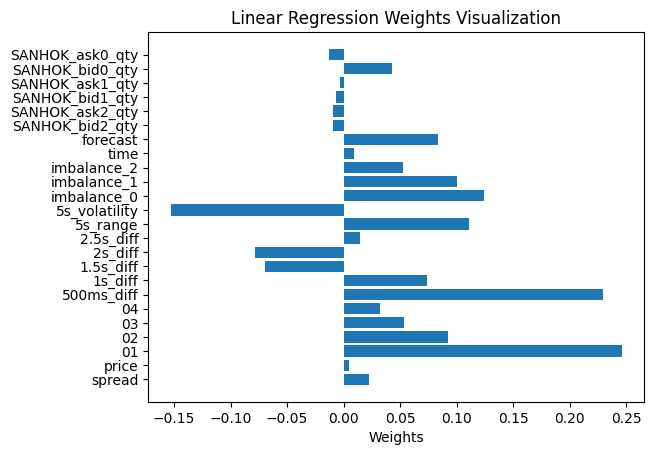

In [7]:
model = Pipeline([
    ('scaler', StandardScaler()),
    # ('mlp', MLPRegressor(hidden_layer_sizes=(10,)))
    ('lin_reg', LinearRegression())
    # ('rf', HistGradientBoostingRegressor(max_depth=3))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print('r2_score = ', r2_score(y_train, y_pred))

_, ax = plt.subplots()
ax.barh(X_train.columns, model.named_steps['lin_reg'].coef_)

ax.set_xlabel('Weights')
ax.set_title('Linear Regression Weights Visualization')

plt.show()

In [8]:
y_pred = model.predict(X_val)
print('r2_score = ', r2_score(y_val, y_pred))

r2_score =  0.12396984287923174


In [9]:
NUM_TRAIN = 50
NUM_VAL = 10

Xs = []
ys = []

for i in tqdm(range(NUM_TRAIN)):
    df = pd.read_feather(f'{data_dir}/train_{i}.feather').set_index('timestamp')
    X, y = prepare_simple_df(df)
    Xs.append(X)
    ys.append(y)

X_train = pd.concat(Xs).values
y_train = pd.concat(ys).values.reshape(-1, 1)

Xs = []
ys = []

for i in tqdm(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)):
    df = pd.read_feather(f'{data_dir}/train_{i}.feather').set_index('timestamp')
    X, y = prepare_simple_df(df)
    Xs.append(X)
    ys.append(y)

X_val= pd.concat(Xs).values
y_val = pd.concat(ys).values.reshape(-1, 1)

100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


In [10]:
X_train.shape

(6740439, 24)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [12]:
class CustomBatchDataset(Dataset):
    def __init__(self, features, labels, batch_size):
        """
        Initialization of the dataset.
        :param features: A 3D tensor containing the features.
        :param labels: A tensor containing the labels.
        :param batch_size: The size of each batch.
        """
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.n_samples = features.shape[0]

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return (self.n_samples + self.batch_size - 1) // self.batch_size

    def __getitem__(self, index):
        """
        Generates one batch of data.
        :param index: The index of the batch to return.
        """
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.n_samples)
        
        X = self.features[start:end]
        y = self.labels[start:end]

        return X, y

In [13]:
class SimpleRegressionNN(nn.Module):
    def __init__(self, input_size, hidden, tail_size):
        super().__init__()
        self.fc11 = nn.Linear(input_size - tail_size, hidden)
        self.relu = nn.ReLU()
        self.fc12 = nn.Linear(hidden, 1)
        self.fc2 = nn.Linear(tail_size, 1)
        # self.alpha = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=True)
        self.tail_size = tail_size

    def forward(self, x):
        if self.tail_size > 0:
            first = self.relu(self.fc11(x[:, :-self.tail_size]))
            first = self.fc12(first)
            second = self.fc2(x[:, -self.tail_size:])
            return first * (1 + second)
        else:
            first = self.relu(self.fc11(x))
            first = self.fc12(first)
            return first

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

BATCH_SIZE = 100000

train_data = DataLoader(CustomBatchDataset(X_train_tensor, y_train_tensor, BATCH_SIZE), batch_size=1, shuffle=False, num_workers=4, prefetch_factor=10)
val_data = DataLoader(CustomBatchDataset(X_val_tensor, y_val_tensor, BATCH_SIZE), batch_size=1, shuffle=False, num_workers=4, prefetch_factor=10)

# 2. Define the model
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, tail_size):
        super(RegressionNN, self).__init__()
        self.fc11 = nn.Linear(input_size - tail_size, hidden_1)
        self.relu = nn.ReLU()
        self.fc12 = nn.Linear(hidden_1, hidden_2)
        self.fc13 = nn.Linear(hidden_2, 1)
        self.fc2 = nn.Linear(tail_size, 1)
        # self.alpha = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=True)
        self.tail_size = tail_size

    def forward(self, x):
        if self.tail_size > 0:
            first = self.relu(self.fc11(x[:, :-self.tail_size]))
            first = self.relu(self.fc12(first))
            first = self.fc13(first)
            second = self.fc2(x[:, -self.tail_size:])
            return first * (1 + second)
        else:
            first = self.relu(self.fc11(x))
            first = self.relu(self.fc12(first))
            first = self.fc13(first)
            return first

print(device)
model = SimpleRegressionNN(X_train.shape[1], 50, 2).to(device)

cuda


In [ ]:
# 3. Training pipeline
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(200): # number of epochs
    model.train()
    actuals = []
    predictions = []
    for inputs, targets in train_data:
        inputs, targets = inputs.to(device).squeeze(0), targets.to(device).squeeze(0)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.detach().cpu().numpy())
    train_r2_score = r2_score(actuals, predictions)

    # 4. Validation pipeline
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_data:
            inputs, targets = inputs.to(device).squeeze(0), targets.to(device).squeeze(0)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    val_r2_score = r2_score(actuals, predictions)
    print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss / len(val_data)}, Train R2 Score: {train_r2_score}, Val R2 Score: {val_r2_score}')

Epoch 0, Loss: 1.5040221214294434, Val Loss: 1.7781723737716675, Train R2 Score: 0.020860388113793538, Val R2 Score: 0.043648098626593024
Epoch 1, Loss: 1.4469579458236694, Val Loss: 1.7577377557754517, Train R2 Score: 0.059934273295551344, Val R2 Score: 0.054812205274597514
Epoch 2, Loss: 1.4175881147384644, Val Loss: 1.7419848442077637, Train R2 Score: 0.07496663342600884, Val R2 Score: 0.06329855683383001
Epoch 3, Loss: 1.3906302452087402, Val Loss: 1.7274357165609087, Train R2 Score: 0.08539191754068676, Val R2 Score: 0.07110398348293523
Epoch 4, Loss: 1.3618357181549072, Val Loss: 1.714389715875898, Train R2 Score: 0.09363021723336051, Val R2 Score: 0.07810530292662021
Epoch 5, Loss: 1.3328824043273926, Val Loss: 1.7028638890811376, Train R2 Score: 0.10038760986295603, Val R2 Score: 0.08429966351714346
Epoch 6, Loss: 1.3058860301971436, Val Loss: 1.6926801630428858, Train R2 Score: 0.10606065187474689, Val R2 Score: 0.08977734048128772
Epoch 7, Loss: 1.2808380126953125, Val Loss: 

In [ ]:
def prepare_time_series(df):
    ts = ((df.index - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')
    seq_len = 20

    dfs = [df[[]].copy() for _ in range(seq_len)]

    cols = dict()

    price_df = ((df.SANHOK_bid0_price + df.SANHOK_ask0_price) / 2)
    price = price_df.values
    cols['price'] = price
    cols['v_01'] = ((df.SANHOK_bid1_price + df.SANHOK_ask1_price) / 2).values - price
    cols['v_02'] = ((df.SANHOK_bid2_price + df.SANHOK_ask2_price) / 2).values - price
    # cols['v_03'] = ((df.SANHOK_bid3_price + df.SANHOK_ask3_price) / 2).values - price
    # cols['v_04'] = ((df.SANHOK_bid4_price + df.SANHOK_ask4_price) / 2).values - price
    cols['500ms'] = get_past_price(ts, price, window)[0] - price
    cols['1s'] = get_past_price(ts, price, window * 2)[0] - price
    cols['2s'] = get_past_price(ts, price, window * 4)[0] - price
    cols['5s_range'] = (price_df.rolling(window='5s', closed='both').min() - price_df.rolling(window='5s', closed='both').max()).values
    cols['5s_volatility'] = price_df.rolling(window='5s', closed='both').std()
    mean_val = cols['5s_volatility'].mean()
    cols['5s_volatility'] = cols['5s_volatility'].fillna(mean_val).values

    for i in range(3):
        cols[f'bid{i}_qty'] = df[f'SANHOK_bid{i}_qty'].values
        cols[f'ask{i}_qty'] = df[f'SANHOK_ask{i}_qty'].values

    for i in range(1, seq_len + 1):
        for key, value in cols.items():
            new_value = get_past_price(ts, value, window * i)[0]
            dfs[-i][f'{key}_diff'] = new_value - value
            cols[key] = new_value

    data = np.stack([df.to_numpy() for df in dfs])

    return np.transpose(data, (1, 2, 0)) # bs nf seq

In [ ]:
NUM_TRAIN_FILES = 10
NUM_VAL_FILES = 3

df_train = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))]).set_index('timestamp')
df_val = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES, NUM_TRAIN_FILES + NUM_VAL_FILES))]).set_index('timestamp')

features = [column for column in df_train.columns if column.startswith('SANHOK')]

X_train = df_train[features]
X_val = df_val[features]

# scaler = StandardScaler()

# X_train_scaled_np = scaler.fit_transform(X_train)
# X_val_scaled_np = scaler.transform(X_val)

# X_train_scaled = pd.DataFrame(X_train_scaled_np, index=X_train.index, columns=X_train.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled_np, index=X_val.index, columns=X_val.columns)

X_train_ts = prepare_time_series(X_train)
X_val_ts = prepare_time_series(X_val)

y_train = df_train['target'].values
y_val = df_val['target'].values

X_train_ts.shape

In [ ]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_ts, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_ts, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# scaler = preprocessing.StandardScaler()
# sk_train_scaled = scaler.fit_transform(train[columns])
# sk_test_scaled = scaler.transform(test[columns])

BATCH_SIZE = 10000

train_data = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
val_data = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

# for feature_batch, target_batch in train_data:
#     print("Feature batch shape:", feature_batch.shape)  # [batch_size, features, time steps]
#     print("Target batch shape:", target_batch.shape)  # [batch_size]

# 2. Define the model
class GruNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size * num_layers, 1)

    def forward(self, x):
        x = self.norm(x)
        x = torch.transpose(x, 1, 2)
        out = self.gru(x)[1]
        out = out.transpose(0, 1)
        out = out.flatten(1, 2)
        res = self.fc(out).squeeze(-1)

        return res

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = GruNN(X_train_ts.shape[1], 50, 3).to(device)

# 3. Training pipeline
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(100): # number of epochs
    model.train()
    actuals = []
    predictions = []
    for inputs, targets in train_data:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.detach().cpu().numpy())
    train_r2_score = r2_score(actuals, predictions)

    # 4. Validation pipeline
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    val_r2_score = r2_score(actuals, predictions)
    print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss / len(val_data)}, Train R2 Score: {train_r2_score}, Val R2 Score: {val_r2_score}')